# Modeling and evaluation
###  Multi-class classification

### Outline
  * Import training data
  * Categorical encoding for the machine "model"
  * Target integer encoding
  * Train-validation-test split
  * MLP model
  * MLP model optimization
  * LightGBM

In [175]:
# Import the necessary libraries
import os
from datetime import datetime, timedelta

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import custom_object_scope, to_categorical
from lightgbm import LGBMClassifier
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [176]:
# Style for the plots
sns.set_style("darkgrid")
sns.set_palette("Set2")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

### Load Data

Load the training data which is created at the feature engineering stage

In [177]:
# Load the training data
train_data = pd.read_parquet("./data/training_data.parquet")

In [178]:
train_data.head()

,machineID,datetime,volt_mean_4h,volt_std_4h,rotate_mean_4h,rotate_std_4h,pressure_mean_4h,pressure_std_4h,vibration_mean_4h,vibration_std_4h,...,error3_sum_48h,error4_sum_48h,error5_sum_48h,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-03 05:00:00,180.694192,9.610191,485.046875,46.151381,95.428381,4.437964,37.832936,6.458281,...,0.0,0.0,0.0,20.958333,215.958333,155.958333,170.958333,model3,18,Normal
1,1,2015-01-03 06:00:00,180.666104,9.621991,469.576558,39.616761,94.209279,2.410554,42.215156,9.533812,...,0.0,0.0,0.0,21.000000,216.000000,156.000000,171.000000,model3,18,comp4
2,1,2015-01-03 07:00:00,180.472154,9.754595,463.636015,32.652890,97.226801,5.232113,45.090099,8.898822,...,0.0,0.0,0.0,21.041667,216.041667,156.041667,171.041667,model3,18,comp4
3,1,2015-01-03 08:00:00,172.821801,5.835065,501.168525,47.092576,96.874856,5.396217,45.555083,9.089829,...,0.0,0.0,0.0,21.083333,216.083333,156.083333,171.083333,model3,18,comp4
4,1,2015-01-03 09:00:00,172.153274,5.786929,492.435436,52.918165,95.204932,7.893687,49.398795,2.469875,...,0.0,0.0,0.0,21.125000,216.125000,156.125000,171.125000,model3,18,comp4


### Class imbalance 

Data is extreamly imbalanced. Failures are rare. This will be challenging and we need to deal with it. 

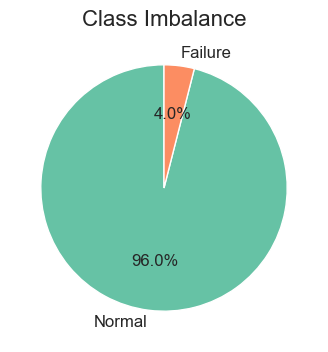

In [179]:
# For a better visualization, plot failure vs, Normal
# Bundle the comp1, comp2, comp3, comp4 together as "Failure" in a separate dataframe
grouped = (
    train_data["failure"]
    .replace(["comp1", "comp2", "comp3", "comp4"], "Failure")
    .value_counts()
)
# plot the pie chart
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    grouped.values,
    labels=grouped.index,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 12},
)
ax.set_title("Class Imbalance", fontsize=16)
plt.show()

### Categorical encoding

The only categorical feature we have is model, we will do dummy encoding. 

In [180]:
# Dummy encode the model feature
train_data = pd.get_dummies(train_data, columns=["model"])

Convert the target classes to integers. We have 5 classes. Normal and component failures 1 - 4. 

In [181]:
mapping = {"Normal": 0, "comp1": 1, "comp2": 2, "comp3": 3, "comp4": 4}
train_data["failure"] = train_data["failure"].apply(lambda x: mapping[x])
train_data.head()

,machineID,datetime,volt_mean_4h,volt_std_4h,rotate_mean_4h,rotate_std_4h,pressure_mean_4h,pressure_std_4h,vibration_mean_4h,vibration_std_4h,...,comp1,comp2,comp3,comp4,age,failure,model_model1,model_model2,model_model3,model_model4
0,1,2015-01-03 05:00:00,180.694192,9.610191,485.046875,46.151381,95.428381,4.437964,37.832936,6.458281,...,20.958333,215.958333,155.958333,170.958333,18,0,False,False,True,False
1,1,2015-01-03 06:00:00,180.666104,9.621991,469.576558,39.616761,94.209279,2.410554,42.215156,9.533812,...,21.000000,216.000000,156.000000,171.000000,18,4,False,False,True,False
2,1,2015-01-03 07:00:00,180.472154,9.754595,463.636015,32.652890,97.226801,5.232113,45.090099,8.898822,...,21.041667,216.041667,156.041667,171.041667,18,4,False,False,True,False
3,1,2015-01-03 08:00:00,172.821801,5.835065,501.168525,47.092576,96.874856,5.396217,45.555083,9.089829,...,21.083333,216.083333,156.083333,171.083333,18,4,False,False,True,False
4,1,2015-01-03 09:00:00,172.153274,5.786929,492.435436,52.918165,95.204932,7.893687,49.398795,2.469875,...,21.125000,216.125000,156.125000,171.125000,18,4,False,False,True,False


In [182]:
train_data.columns

Index(['machineID', 'datetime', 'volt_mean_4h', 'volt_std_4h',
       'rotate_mean_4h', 'rotate_std_4h', 'pressure_mean_4h',
       'pressure_std_4h', 'vibration_mean_4h', 'vibration_std_4h',
       'volt_mean_48h', 'volt_std_48h', 'rotate_mean_48h', 'rotate_std_48h',
       'pressure_mean_48h', 'pressure_std_48h', 'vibration_mean_48h',
       'vibration_std_48h', 'error1_sum_48h', 'error2_sum_48h',
       'error3_sum_48h', 'error4_sum_48h', 'error5_sum_48h', 'comp1', 'comp2',
       'comp3', 'comp4', 'age', 'failure', 'model_model1', 'model_model2',
       'model_model3', 'model_model4'],
      dtype='object')

### Data split: Train, Validation and Testing

A careful data split is necessary. This is because we are based on a timeseries data and the features are created with a lagged window. A random split would cause a data leakage. 

We will just split the data with the time, without shuffling. We will split into train, validation and test sets. 

Another issue to consider when splitting lagged features is to avoid using the training set information in the validation set, i.e., avoid sharing time windows between the sets. For this reason, we will introduce a gap of 48 hours between the splits (consistent with our largest window size). 

#### Determine the split dates 

We will do a 70/15/15 split

In [184]:
# Start date of data
start_date = datetime(2015, 1, 3, 5, 0, 0)
# Total number of days in your dataset
total_days = 365
# Percentage of data for training
train_percentage = 0.7

train_split_date = start_date + timedelta(days=int(total_days * train_percentage))
remaining_days = total_days - int(total_days * train_percentage)

validation_split_date = train_split_date + timedelta(days=int(remaining_days / 2))

print("Train split date: ", train_split_date)
print("Validation split date: ", validation_split_date)

Train split date:  2015-09-15 05:00:00
Validation split date:  2015-11-09 05:00:00


In [393]:
def split_data(df, train_last_date, valid_last_date):
    """A function to split the data into train, validation and test sets.

    Parameters
    ----------
    df : dataframe
        The dataframe to be split.
    train_last_date : string
        The last date of the training set.
    valid_last_date : string
        The last date of the validation set.

    Returns
    -------
    X_train : dataframe
        The training set.
    y_train : dataframe
        The labels of the training set.
    X_valid : dataframe
        The validation set.
    y_valid : dataframe
        The labels of the validation set.
    X_test : dataframe
        The test set.
    y_test : dataframe
        The labels of the test set.
    """
    train_end_date = pd.to_datetime(train_last_date)
    # Adding a 48-hour gap
    valid_start_date = train_end_date + pd.Timedelta(hours=48)
    valid_end_date = pd.to_datetime(valid_last_date)
    # Adding a 48-hour gap
    test_start_date = valid_end_date + pd.Timedelta(hours=48)
    df_train = df[df["datetime"] <= train_end_date]
    df_valid = df[
        (df["datetime"] > valid_start_date) & (df["datetime"] <= valid_end_date)
    ]
    df_test = df[df["datetime"] > test_start_date]

    X_train = df_train.drop(["datetime", "machineID", "failure"], axis=1)
    y_train = df_train["failure"]
    X_valid = df_valid.drop(["datetime", "machineID", "failure"], axis=1)
    y_valid = df_valid["failure"]
    X_test = df_test.drop(["datetime", "machineID", "failure"], axis=1)
    y_test = df_test["failure"]

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [394]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(
    train_data, "2015-09-15 05:00:00", "2015-11-09 05:00:00"
)

# Convert the datatypes of the features to float64, so that it can be used in the neural network
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")
X_valid = X_valid.astype("float64")

In [395]:
# Save the feature names for later use, when we need to plot the feature importance
feature_list = list(X_train.columns)

In [187]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((616784, 30), (616784,), (127205, 30), (127205,), (122506, 30), (122506,))

#### How much data do we have in each set

We had to make it a dataframe, for the report. 

In [188]:
train_class_count = y_train.value_counts()
valid_class_count = y_valid.value_counts()
test_class_count = y_test.value_counts()

class_count_df = pd.DataFrame(
    {"train": train_class_count, "valid": valid_class_count, "test": test_class_count}
)
# class_count_df = class_count_df.sort_index()
class_count_df.index = ["comp1", "comp2", "comp3", "comp4", "Normal"]
class_count_df.columns = ["Training", "Validation", "Test"]
class_count_df

,Training,Validation,Test
comp1,7058,881,1103
comp2,8574,1712,1816
comp3,4268,762,737
comp4,5473,1034,983
Normal,591411,122816,117867


In [396]:
y_train.value_counts(normalize=True)

failure
0    0.958862
2    0.013901
1    0.011443
4    0.008873
3    0.006920
Name: proportion, dtype: float64

### Class Imbalance

There are many ways to deal with the class imbalance. This includes resampling the dataset (undersampling, oversampling the minority) or adjustig the class weights. Otherwise, we also use an approprite evaluation metrics. Using accuracy is a bad idea for our problem.  Instead, we should use metrics such as precision and recall. 

For our application, a higher recall is what we need. Recall = TP / (TP + FN) measures how good our model finds the actual positives. The assumption is if there will be a failure which we didn't predict correctly, it will lead to a higher overall cost. Since we have a multiple classes, our metric choice is macro average recall. 

However, since our overall cases of failures are only 4 %, It will be difficult to train a proper model. Hence, we will use class 
weighting technique. 



#### Class weights for a balanced outcome

In [401]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)

# Create dictionary mapping class indices to class weights
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.2085804964736875,
 1: 17.477585718333806,
 2: 14.38731047352461,
 3: 28.902717900656047,
 4: 22.539155856020464}

### Standardize the data

Make it zero mean and unit variance. 

Standardizing the data equalizes the impact of features and improve convergence. 

In [398]:
# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [196]:
# convert y_train and y_test to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=5)
y_valid = to_categorical(y_valid, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

y_train.shape, y_valid.shape, y_test.shape

((616784, 5), (127205, 5), (122506, 5))

### Multi-Layer Perceptron (MLP)

We start with a simple neural network and later try to fine-tune the hyperparameters. 

We will be using the keras framework.

In [402]:
# Lets create a custom metric to calculate the macro average recall
def macro_recall(y_true, y_pred):
    """A function to calculate the macro average recall metric.
    Can be used as a metric in Keras models.

    Parameters
    ----------
    y_true : dataframe
        The actual labels.
    y_pred : dataframe
        The predicted labels.

    Returns
    -------
    macro_recall : float
        The macro average recall value.
    """
    # Compute macro-average recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_positives = K.sum(y_true, axis=0)
    recall = true_positives / (actual_positives + K.epsilon())
    macro_recall = K.mean(recall)
    return macro_recall

### Manual fine-tuning 

After manually experimenting with some values for all the hyperparameters, we settled for:

- Two hidden layers, with 300 neurons each.
- Dropout: 0.2
- activation function: Relu
- Optimizer: Adam with learning rate 0.001
- batch_size = 1024

Since our problem is a multi-class classification problem, we use the categorical-cross entropy as a loss function.

In [309]:
# A function to train an MLP model
def train_model(X_train, y_train, X_val, y_val, epochs=5, batch_size=512):
    """A function to train an MLP model.

    Parameters
    ----------
    X_train : dataframe
        The training set.
    y_train : dataframe
        The labels of the training set.
    X_val : dataframe
        The validation set.
    y_val : dataframe
        The labels of the validation set.
    epochs : int, optional
        The number of epochs to train the model. The default is 5.
    batch_size : int, optional
        The batch size to train the model. The default is 512.

    Returns
    -------
    model : keras model
        The trained model.
    history : keras history
        The history of the training process.
    """
    # create a model
    model = Sequential()
    model.add(Dense(300, input_shape=(X_train.shape[1],), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(300, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation="softmax"))

    optimizer = Adam(learning_rate=0.001)
    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer)

    # fit the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        class_weight=class_weight_dict,
    )

    return model, history

We run the training for 20 epochs 

In [310]:
model, history = train_model(
    X_train, y_train, X_valid, y_valid, epochs=20, batch_size=1024
)

Epoch 1/20
603/603 [==============================] - 6s 10ms/step - loss: 0.3108 - val_loss: 0.4191
Epoch 2/20
603/603 [==============================] - 8s 13ms/step - loss: 0.2182 - val_loss: 0.4013
Epoch 3/20
603/603 [==============================] - 8s 14ms/step - loss: 0.1880 - val_loss: 0.3490
Epoch 4/20
603/603 [==============================] - 9s 15ms/step - loss: 0.1679 - val_loss: 0.3018
Epoch 5/20
603/603 [==============================] - 8s 13ms/step - loss: 0.1517 - val_loss: 0.3135
Epoch 6/20
603/603 [==============================] - 7s 11ms/step - loss: 0.1386 - val_loss: 0.2956
Epoch 7/20
603/603 [==============================] - 5s 8ms/step - loss: 0.1254 - val_loss: 0.2757
Epoch 8/20
603/603 [==============================] - 7s 12ms/step - loss: 0.1174 - val_loss: 0.2440
Epoch 9/20
603/603 [==============================] - 8s 13ms/step - loss: 0.1081 - val_loss: 0.3335
Epoch 10/20
603/603 [==============================] - 6s 10ms/step - loss: 0.1051 - val_los

In [276]:
model.summary()

Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_599 (Dense)           (None, 256)               7936      
                                                                 
 dropout_280 (Dropout)       (None, 256)               0         
                                                                 
 dense_600 (Dense)           (None, 256)               65792     
                                                                 
 dropout_281 (Dropout)       (None, 256)               0         
                                                                 
 dense_601 (Dense)           (None, 5)                 1285      
                                                                 
Total params: 75,013
Trainable params: 75,013
Non-trainable params: 0
_________________________________________________________________


### Loss curve

In [311]:
# plot the training loss and validation loss
def plot_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

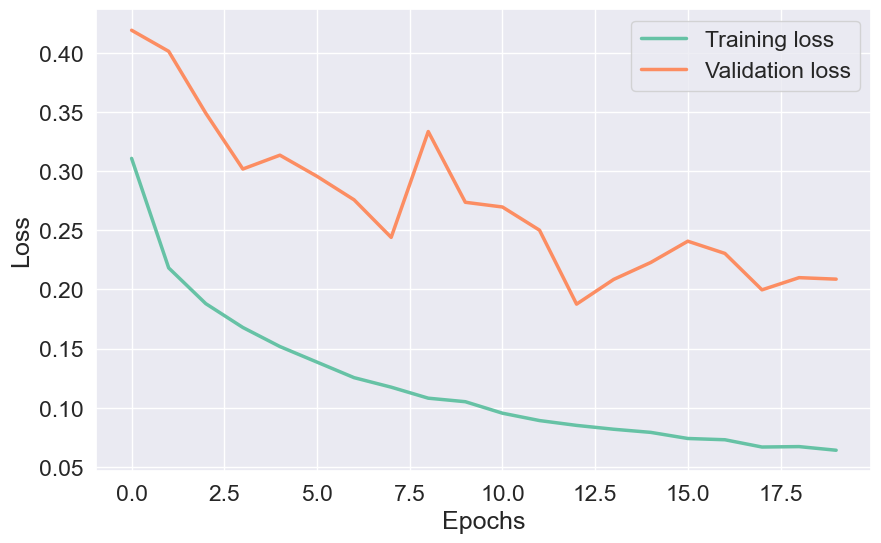

In [312]:
plot_history(history)

The training loss decreased in a smooth way and the validation loss didn't improve after the 11th epoch

### Helper functions for model evaluation

In [403]:
labels = ["Normal", "comp1", "comp2", "comp3", "comp4"]


def evaluate_model(model, X, y):
    """A function to evaluate a model.

    Parameters
    ----------
    model : keras model
        The trained model.
    X : dataframe
        The features.
    y : dataframe

    Returns
    -------
    cm : array
        The confusion matrix.
    report : dataframe
        The classification report.
    """

    print(X.shape, y.shape)
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    report = classification_report(y_true, y_pred, output_dict=True)

    # convert report to dataframe
    report = pd.DataFrame(report).transpose()

    print("classification report")
    print(report)
    print("confusion matrix")
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    print(df_cm)

    return cm, report


# Since our primary metric is macro average recall, lets crate a function to calculate it
def get_recall_scores(clf_report):
    """A function to calculate the recall scores from a classification report.

    Parameters
    ----------
    clf_report : dataframe
        The classification report.

    Returns
    -------
    recall_df : dataframe
        The recall scores.
    """

    # round to two decimal places in dataframe
    report_test = clf_report.round(2)
    # drop accuracy
    report_test = report_test.drop(["accuracy"], axis=0)
    # drop f1-score and support
    report_test = report_test.drop(["f1-score", "support"], axis=1)
    # rename index to 'Normal', 'comp1', 'comp2', 'comp3', 'comp4'
    report_test.index = [
        "Normal",
        "comp1",
        "comp2",
        "comp3",
        "comp4",
        "macro avg",
        "weighted avg",
    ]

    # get only recall column as a dataframe
    recall_df = report_test.loc[:, ["recall"]]
    return recall_df

#### Performance on the validation set

In [337]:
cm_valid, report_valid = evaluate_model(model, X_valid, y_valid)
recall_no_hpo_valid = get_recall_scores(report_valid)
recall_no_hpo_valid

(127205, 30) (127205, 5)
3976/3976 [==============================] - 4s 908us/step
classification report
              precision    recall  f1-score        support
0              0.994015  0.938542  0.965483  122816.000000
1              0.192816  0.761635  0.307728     881.000000
2              0.338131  0.809579  0.477026    1712.000000
3              0.413174  0.905512  0.567434     762.000000
4              0.434303  0.837524  0.571995    1034.000000
accuracy       0.934562  0.934562  0.934562       0.934562
macro avg      0.474488  0.850558  0.577933  127205.000000
weighted avg   0.971610  0.934562  0.948770  127205.000000
confusion matrix
        Normal  comp1  comp2  comp3  comp4
Normal  115268   2788   2689    951   1120
comp1      198    671     11      0      1
comp2      286     12   1386     25      3
comp3       60      2      6    690      4
comp4      150      7      7      4    866


,recall
Normal,0.94
comp1,0.76
comp2,0.81
comp3,0.91
comp4,0.84
macro avg,0.85
weighted avg,0.93


macro average recall of 0.85 - not bad! 

component 1 had the smallest recall. 

#### Performance on the test set

In [349]:
cm_test, report_test = evaluate_model(model, X_test, y_test)
recall_test_no_hpo = get_recall_scores(report_test)
recall_test_no_hpo

(122506, 30) (122506, 5)
3829/3829 [==============================] - 5s 1ms/step
classification report
              precision    recall  f1-score        support
0              0.994866  0.937133  0.965137  117867.000000
1              0.237297  0.783318  0.364250    1103.000000
2              0.350930  0.830947  0.493460    1816.000000
3              0.440832  0.919946  0.596044     737.000000
4              0.429000  0.872838  0.575260     983.000000
accuracy       0.933554  0.933554  0.933554       0.933554
macro avg      0.490585  0.868836  0.598830  122506.000000
weighted avg   0.970626  0.933554  0.947386  122506.000000
confusion matrix
        Normal  comp1  comp2  comp3  comp4
Normal  110457   2759   2696    846   1109
comp1      174    864     38      1     26
comp2      282      5   1509     13      7
comp3       35     11     13    678      0
comp4       79      2     44      0    858


,recall
Normal,0.94
comp1,0.78
comp2,0.83
comp3,0.92
comp4,0.87
macro avg,0.87
weighted avg,0.93


The overall macro average recall is very good! 

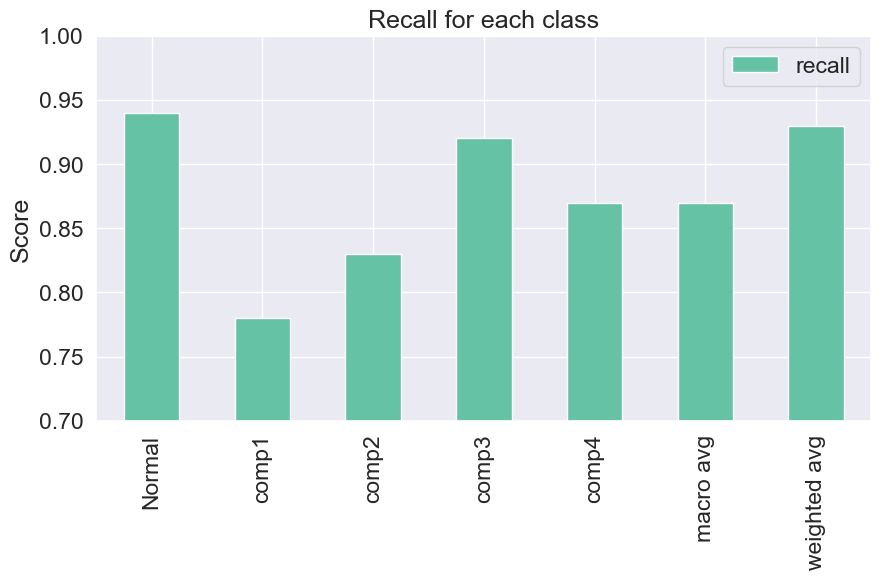

In [323]:
# Plot the recall scores for each class
recall_test_no_hpo.plot(kind="bar", figsize=(10, 5))
plt.ylim(0.7, 1.0)
plt.title("Recall for each class")
plt.ylabel("Score")
plt.show()

In [317]:
# The confusion matrix for test set as a dataframe
cm_test_df_no_hpo = pd.DataFrame(cm_test, index=labels, columns=labels)
cm_test_df_no_hpo

,Normal,comp1,comp2,comp3,comp4
Normal,110457,2759,2696,846,1109
comp1,174,864,38,1,26
comp2,282,5,1509,13,7
comp3,35,11,13,678,0
comp4,79,2,44,0,858


In [320]:
# create a table of the confusion matrix for the validation set
cm_valid_df_no_hpo = pd.DataFrame(cm_valid, index=labels, columns=labels)
cm_valid_df_no_hpo

,Normal,comp1,comp2,comp3,comp4
Normal,115268,2788,2689,951,1120
comp1,198,671,11,0,1
comp2,286,12,1386,25,3
comp3,60,2,6,690,4
comp4,150,7,7,4,866


### MLP hyperparameter optimization with Optuna

Lets try to perform hyperparameter optimization. We will use a very cool optimization framework called Optuna. 

Optuna offeres diffrent sampling technicques, we use the Bayesian based TPE (Tree-structured Parzen Estimator) algorithm. TPESampler. For more information about the sampler see https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html

We will optimize:

- number of layers
- number of units
- learning rate 
- activation function (ReLu, LeakyReLu)

To speed up training, we use early stopping and optunas pruning callback. When the trials are not promising, it will skip them.

In [261]:
# create a directory called models to save the best model if it doesn't exist already
if not os.path.exists("models"):
    os.makedirs("models")


def train_model_optuna(
    X_train, y_train, X_val, y_val, n_trials=2, epochs=5, batch_size=512
):
    """A function to train a model using Optuna.

    Parameters
    ----------
    X_train : dataframe
        The training features.
    y_train : dataframe
        The training labels.
    X_val : dataframe
        The validation features.
    y_val : dataframe
        The validation labels.
    n_trials : int
        The number of trials for Optuna to run.
    epochs : int
        The number of epochs to train the model.
    batch_size : int
        The batch size.

    Returns
    -------
    model : keras model
        The trained model.
    history : dataframe
        The training history.
    """

    def objective(trial):
        # Define the hyperparameters to optimize
        num_hidden_layers = trial.suggest_int("num_hidden_layers", 2, 5)
        dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
        # activation = trial.suggest_categorical("activation", ["relu", "LeakyReLU"])

        # Create the model
        model = Sequential()
        model.add(
            Dense(
                trial.suggest_int("num_units_0", 64, 512),
                input_shape=(X_train.shape[1],),
                activation="relu",
            )
        )

        # Add hidden layers
        for i in range(1, num_hidden_layers):
            model.add(
                Dense(trial.suggest_int(f"num_units_{i}", 64, 512), activation="relu")
            )
            model.add(Dropout(dropout_rate))

        # Add output layer
        model.add(Dense(y_train.shape[1], activation="softmax"))

        # Compile the model
        model.compile(
            loss="categorical_crossentropy", optimizer=Adam(learning_rate=learning_rate)
        )

        # Define pruning and early stopping callbacks
        pruning_callback = TFKerasPruningCallback(trial, "val_loss")
        es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

        # Fit the model
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            verbose=1,
            callbacks=[pruning_callback, es],
        )

        # Calculate the macro recall on the validation set after training
        score = macro_recall(y_val, model.predict(X_val))

        # Add the model weights to the user_attrs dictionary of the trial.
        # We use this to retrieve the best model at the end.
        trial.set_user_attr("model_weights", model.get_weights())

        # Return the validation accuracy as the objective
        return score

    # Create an Optuna study
    study = optuna.create_study(
        direction="maximize", sampler=optuna.samplers.TPESampler(seed=123)
    )

    # Optimize the objective function
    study.optimize(objective, n_trials=n_trials)

    # Print the best hyperparameters and validation accuracy
    print(
        f"Best trial: {study.best_trial.params}, Validation accuracy: {study.best_trial.value:.4f}"
    )

    # Save the best model to a file, 'best_model.h5' in the models directory
    # We need it later
    best_model = Sequential()
    best_model.add(
        Dense(
            study.best_trial.params["num_units_0"],
            input_shape=(X_train.shape[1],),
            activation="relu",
        )
    )

    for i in range(1, study.best_trial.params["num_hidden_layers"]):
        best_model.add(
            Dense(study.best_trial.params[f"num_units_{i}"], activation="relu")
        )
        best_model.add(Dropout(study.best_trial.params["dropout_rate"]))

    best_model.add(Dense(y_train.shape[1], activation="softmax"))
    best_model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=study.best_trial.params["learning_rate"]),
    )
    best_model.set_weights(study.best_trial.user_attrs["model_weights"])
    best_model.save("./models/best_model.h5")

    return study.best_trial.params, study

#### Run the experiment

- 25 trials and 15 epochs

In [283]:
best_params, study = train_model_optuna(
    X_train, y_train, X_valid, y_valid, n_trials=25, epochs=15, batch_size=1024
)

[I 2023-05-29 14:20:41,866] A new study created in memory with name: no-name-507cb0ed-ff9c-4e99-bcc4-71461b2627bd


Epoch 1/15
603/603 [==============================] - 19s 30ms/step - loss: 0.3032 - val_loss: 0.3499
Epoch 2/15
603/603 [==============================] - 22s 36ms/step - loss: 0.1910 - val_loss: 0.3742
Epoch 3/15
603/603 [==============================] - 20s 34ms/step - loss: 0.1516 - val_loss: 0.3074
Epoch 4/15
603/603 [==============================] - 22s 36ms/step - loss: 0.1264 - val_loss: 0.4182
Epoch 5/15
603/603 [==============================] - 21s 35ms/step - loss: 0.1043 - val_loss: 0.2707
Epoch 6/15
603/603 [==============================] - 21s 35ms/step - loss: 0.0896 - val_loss: 0.2518
Epoch 7/15
603/603 [==============================] - 23s 38ms/step - loss: 0.0741 - val_loss: 0.2211
Epoch 8/15
603/603 [==============================] - 22s 36ms/step - loss: 0.0657 - val_loss: 0.2903
Epoch 9/15
603/603 [==============================] - 19s 31ms/step - loss: 0.0588 - val_loss: 0.2582
Epoch 10/15
603/603 [==============================] - 21s 34ms/step - loss: 0.053

[I 2023-05-29 14:26:06,267] Trial 0 finished with value: 0.8103610873222351 and parameters: {'num_hidden_layers': 4, 'dropout_rate': 0.1, 'learning_rate': 0.0004792414358623592, 'num_units_0': 311, 'num_units_1': 387, 'num_units_2': 253, 'num_units_3': 504}. Best is trial 0 with value: 0.8103610873222351.


Epoch 1/15
603/603 [==============================] - 16s 25ms/step - loss: 0.3119 - val_loss: 0.3887
Epoch 2/15
603/603 [==============================] - 15s 25ms/step - loss: 0.2089 - val_loss: 0.4493
Epoch 3/15
603/603 [==============================] - 17s 28ms/step - loss: 0.1691 - val_loss: 0.2833
Epoch 4/15
603/603 [==============================] - 17s 28ms/step - loss: 0.1433 - val_loss: 0.2380
Epoch 5/15
603/603 [==============================] - 16s 27ms/step - loss: 0.1285 - val_loss: 0.2865
Epoch 6/15
603/603 [==============================] - 14s 24ms/step - loss: 0.1116 - val_loss: 0.3235
Epoch 7/15
603/603 [==============================] - 13s 22ms/step - loss: 0.1027 - val_loss: 0.2564
Epoch 8/15
603/603 [==============================] - 18s 29ms/step - loss: 0.0892 - val_loss: 0.3037
Epoch 9/15
3976/3976 [==============================] - 4s 939us/step


[I 2023-05-29 14:28:35,715] Trial 1 finished with value: 0.8553004264831543 and parameters: {'num_hidden_layers': 4, 'dropout_rate': 0.2, 'learning_rate': 0.0015009027543233906, 'num_units_0': 218, 'num_units_1': 391, 'num_units_2': 260, 'num_units_3': 90}. Best is trial 1 with value: 0.8553004264831543.


Epoch 1/15
603/603 [==============================] - 7s 12ms/step - loss: 0.4124 - val_loss: 0.4720
Epoch 2/15
603/603 [==============================] - 7s 12ms/step - loss: 0.2671 - val_loss: 0.3941
Epoch 3/15
603/603 [==============================] - 7s 12ms/step - loss: 0.2347 - val_loss: 0.3718
Epoch 4/15
603/603 [==============================] - 7s 11ms/step - loss: 0.2103 - val_loss: 0.3721
Epoch 5/15
603/603 [==============================] - 7s 12ms/step - loss: 0.1950 - val_loss: 0.3443
Epoch 6/15
603/603 [==============================] - 5s 9ms/step - loss: 0.1822 - val_loss: 0.3234
Epoch 7/15
603/603 [==============================] - 5s 8ms/step - loss: 0.1708 - val_loss: 0.3280
Epoch 8/15
603/603 [==============================] - 7s 12ms/step - loss: 0.1621 - val_loss: 0.3482
Epoch 9/15
603/603 [==============================] - 7s 12ms/step - loss: 0.1526 - val_loss: 0.2995
Epoch 10/15
603/603 [==============================] - 6s 10ms/step - loss: 0.1468 - val_loss

[I 2023-05-29 14:30:22,256] Trial 2 finished with value: 0.889194667339325 and parameters: {'num_hidden_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.0003527566351720554, 'num_units_0': 142, 'num_units_1': 302}. Best is trial 2 with value: 0.889194667339325.


Epoch 1/15
603/603 [==============================] - 18s 29ms/step - loss: 0.9999 - val_loss: 1.2238
Epoch 2/15
603/603 [==============================] - 21s 34ms/step - loss: 1.0052 - val_loss: 1.3019
Epoch 3/15
603/603 [==============================] - 20s 34ms/step - loss: 1.2626 - val_loss: 1.4253
Epoch 4/15
603/603 [==============================] - 20s 34ms/step - loss: 1.3703 - val_loss: 1.5257
Epoch 5/15
603/603 [==============================] - 19s 32ms/step - loss: 1.4053 - val_loss: 1.6171
Epoch 6/15
3976/3976 [==============================] - 5s 1ms/step


[I 2023-05-29 14:32:25,626] Trial 3 finished with value: 0.0 and parameters: {'num_hidden_layers': 3, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.03534234664650463, 'num_units_0': 389, 'num_units_1': 338, 'num_units_2': 388}. Best is trial 2 with value: 0.889194667339325.


Epoch 1/15
603/603 [==============================] - 7s 11ms/step - loss: 0.3368 - val_loss: 0.3963
Epoch 2/15
603/603 [==============================] - 7s 12ms/step - loss: 0.2222 - val_loss: 0.3089
Epoch 3/15
603/603 [==============================] - 7s 11ms/step - loss: 0.1901 - val_loss: 0.3829
Epoch 4/15
603/603 [==============================] - 7s 12ms/step - loss: 0.1696 - val_loss: 0.3548
Epoch 5/15
603/603 [==============================] - 7s 12ms/step - loss: 0.1538 - val_loss: 0.3154
Epoch 6/15
603/603 [==============================] - 7s 12ms/step - loss: 0.1414 - val_loss: 0.2719
Epoch 7/15
603/603 [==============================] - 6s 9ms/step - loss: 0.1290 - val_loss: 0.3107
Epoch 8/15
603/603 [==============================] - 6s 10ms/step - loss: 0.1195 - val_loss: 0.3003
Epoch 9/15
603/603 [==============================] - 7s 11ms/step - loss: 0.1117 - val_loss: 0.2717
Epoch 10/15
603/603 [==============================] - 7s 12ms/step - loss: 0.1033 - val_los

[I 2023-05-29 14:34:10,146] Trial 4 finished with value: 0.8344270586967468 and parameters: {'num_hidden_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.0004839379635846532, 'num_units_0': 195, 'num_units_1': 347}. Best is trial 2 with value: 0.889194667339325.


Epoch 1/15
597/603 [============================>.] - ETA: 0s - loss: 0.2797

[I 2023-05-29 14:34:13,063] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/15
602/603 [============================>.] - ETA: 0s - loss: 0.2699

[I 2023-05-29 14:34:26,889] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/15
600/603 [============================>.] - ETA: 0s - loss: 0.2775

[I 2023-05-29 14:34:36,664] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/15
603/603 [==============================] - 22s 35ms/step - loss: 0.4353 - val_loss: 0.5277
Epoch 2/15
603/603 [==============================] - 25s 41ms/step - loss: 0.3702 - val_loss: 0.4070
Epoch 3/15
603/603 [==============================] - 23s 39ms/step - loss: 0.3362 - val_loss: 0.5846
Epoch 4/15
603/603 [==============================] - 22s 37ms/step - loss: 0.3758 - val_loss: 0.4735
Epoch 5/15
603/603 [==============================] - 24s 40ms/step - loss: 0.3667 - val_loss: 0.4843
Epoch 6/15
603/603 [==============================] - 18s 30ms/step - loss: 0.3339 - val_loss: 0.5429
Epoch 7/15
3976/3976 [==============================] - 13s 3ms/step


[I 2023-05-29 14:37:25,386] Trial 8 finished with value: 0.8691641688346863 and parameters: {'num_hidden_layers': 5, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.006897370850315689, 'num_units_0': 118, 'num_units_1': 435, 'num_units_2': 334, 'num_units_3': 308, 'num_units_4': 217}. Best is trial 2 with value: 0.889194667339325.


Epoch 1/15
603/603 [==============================] - 11s 17ms/step - loss: 0.3205 - val_loss: 0.4729
Epoch 2/15
603/603 [==============================] - 12s 20ms/step - loss: 0.2475 - val_loss: 0.4357
Epoch 3/15
603/603 [==============================] - 12s 20ms/step - loss: 0.2340 - val_loss: 0.3542
Epoch 4/15
603/603 [==============================] - 13s 21ms/step - loss: 0.2168 - val_loss: 0.4313
Epoch 5/15
603/603 [==============================] - 12s 20ms/step - loss: 0.2048 - val_loss: 0.4631
Epoch 6/15
603/603 [==============================] - 12s 20ms/step - loss: 0.2052 - val_loss: 0.3735
Epoch 7/15
603/603 [==============================] - 10s 17ms/step - loss: 0.1978 - val_loss: 0.3646
Epoch 8/15
3976/3976 [==============================] - 7s 2ms/step


[I 2023-05-29 14:39:08,272] Trial 9 finished with value: 0.8438003659248352 and parameters: {'num_hidden_layers': 2, 'dropout_rate': 0.2, 'learning_rate': 0.011063748563756831, 'num_units_0': 457, 'num_units_1': 293}. Best is trial 2 with value: 0.889194667339325.


Epoch 1/15
603/603 [==============================] - 2s 3ms/step - loss: 0.9269 - val_loss: 1.0663
Epoch 2/15
603/603 [==============================] - 2s 3ms/step - loss: 0.4718 - val_loss: 0.7240
Epoch 3/15
603/603 [==============================] - 2s 3ms/step - loss: 0.3787 - val_loss: 0.6031
Epoch 4/15
603/603 [==============================] - 2s 3ms/step - loss: 0.3387 - val_loss: 0.5538
Epoch 5/15
603/603 [==============================] - 2s 3ms/step - loss: 0.3151 - val_loss: 0.5049
Epoch 6/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2989 - val_loss: 0.4940
Epoch 7/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2866 - val_loss: 0.4830
Epoch 8/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2770 - val_loss: 0.4552
Epoch 9/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2689 - val_loss: 0.4522
Epoch 10/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2618 - val_loss: 0.4442

[I 2023-05-29 14:39:41,192] Trial 10 finished with value: 0.8837345838546753 and parameters: {'num_hidden_layers': 1, 'dropout_rate': 0.5, 'learning_rate': 0.00014315554041847297, 'num_units_0': 67}. Best is trial 2 with value: 0.889194667339325.


Epoch 1/15
603/603 [==============================] - 2s 3ms/step - loss: 0.8089 - val_loss: 0.9470
Epoch 2/15
603/603 [==============================] - 2s 3ms/step - loss: 0.4448 - val_loss: 0.6877
Epoch 3/15
603/603 [==============================] - 3s 4ms/step - loss: 0.3679 - val_loss: 0.5894
Epoch 4/15
603/603 [==============================] - 2s 4ms/step - loss: 0.3315 - val_loss: 0.5385
Epoch 5/15
603/603 [==============================] - 2s 4ms/step - loss: 0.3092 - val_loss: 0.5012
Epoch 6/15
603/603 [==============================] - 2s 4ms/step - loss: 0.2936 - val_loss: 0.4743
Epoch 7/15
603/603 [==============================] - 2s 4ms/step - loss: 0.2819 - val_loss: 0.4619
Epoch 8/15
603/603 [==============================] - 2s 4ms/step - loss: 0.2724 - val_loss: 0.4579
Epoch 9/15
603/603 [==============================] - 2s 4ms/step - loss: 0.2645 - val_loss: 0.4448
Epoch 10/15
603/603 [==============================] - 2s 4ms/step - loss: 0.2576 - val_loss: 0.4358

[I 2023-05-29 14:40:18,428] Trial 11 finished with value: 0.8881816864013672 and parameters: {'num_hidden_layers': 1, 'dropout_rate': 0.5, 'learning_rate': 0.00010268675565005232, 'num_units_0': 113}. Best is trial 2 with value: 0.889194667339325.


Epoch 1/15
603/603 [==============================] - 8s 12ms/step - loss: 0.5899 - val_loss: 0.5765
Epoch 2/15
603/603 [==============================] - 6s 9ms/step - loss: 0.3381 - val_loss: 0.4731
Epoch 3/15
603/603 [==============================] - 5s 8ms/step - loss: 0.2962 - val_loss: 0.4340
Epoch 4/15
603/603 [==============================] - 5s 9ms/step - loss: 0.2708 - val_loss: 0.4178
Epoch 5/15
603/603 [==============================] - 5s 9ms/step - loss: 0.2566 - val_loss: 0.4254
Epoch 6/15
603/603 [==============================] - 6s 9ms/step - loss: 0.2391 - val_loss: 0.3958
Epoch 7/15
603/603 [==============================] - 6s 10ms/step - loss: 0.2264 - val_loss: 0.3757
Epoch 8/15
603/603 [==============================] - 6s 10ms/step - loss: 0.2168 - val_loss: 0.3498
Epoch 9/15
603/603 [==============================] - 6s 10ms/step - loss: 0.2095 - val_loss: 0.3442
Epoch 10/15
603/603 [==============================] - 6s 11ms/step - loss: 0.2011 - val_loss: 0

[I 2023-05-29 14:41:51,230] Trial 12 finished with value: 0.895666778087616 and parameters: {'num_hidden_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.00020641708937144267, 'num_units_0': 147, 'num_units_1': 153}. Best is trial 12 with value: 0.895666778087616.


Epoch 1/15
603/603 [==============================] - 7s 11ms/step - loss: 0.4745 - val_loss: 0.5320
Epoch 2/15
603/603 [==============================] - 7s 11ms/step - loss: 0.2986 - val_loss: 0.4222
Epoch 3/15
603/603 [==============================] - 7s 11ms/step - loss: 0.2603 - val_loss: 0.3985
Epoch 4/15
603/603 [==============================] - 6s 11ms/step - loss: 0.2380 - val_loss: 0.3968
Epoch 5/15
603/603 [==============================] - 7s 11ms/step - loss: 0.2238 - val_loss: 0.3550
Epoch 6/15
603/603 [==============================] - 7s 12ms/step - loss: 0.2086 - val_loss: 0.3805
Epoch 7/15
603/603 [==============================] - 8s 13ms/step - loss: 0.1973 - val_loss: 0.3418
Epoch 8/15
603/603 [==============================] - 8s 13ms/step - loss: 0.1886 - val_loss: 0.3664
Epoch 9/15
603/603 [==============================] - 6s 11ms/step - loss: 0.1813 - val_loss: 0.3382
Epoch 10/15
603/603 [==============================] - 6s 10ms/step - loss: 0.1734 - val_lo

[I 2023-05-29 14:43:37,014] Trial 13 finished with value: 0.8939281702041626 and parameters: {'num_hidden_layers': 2, 'dropout_rate': 0.4, 'learning_rate': 0.00025886244491000326, 'num_units_0': 152, 'num_units_1': 171}. Best is trial 12 with value: 0.895666778087616.


Epoch 1/15
602/603 [============================>.] - ETA: 0s - loss: 0.5150

[I 2023-05-29 14:43:45,026] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/15
603/603 [==============================] - 13s 20ms/step - loss: 0.6855 - val_loss: 0.6448
Epoch 2/15
603/603 [==============================] - 13s 22ms/step - loss: 0.4079 - val_loss: 0.5633
Epoch 3/15
603/603 [==============================] - 12s 20ms/step - loss: 0.3590 - val_loss: 0.5528
Epoch 4/15
603/603 [==============================] - 12s 21ms/step - loss: 0.3285 - val_loss: 0.4790
Epoch 5/15
603/603 [==============================] - 12s 20ms/step - loss: 0.3117 - val_loss: 0.4845
Epoch 6/15
603/603 [==============================] - 11s 19ms/step - loss: 0.2978 - val_loss: 0.4429
Epoch 7/15
603/603 [==============================] - 12s 20ms/step - loss: 0.2839 - val_loss: 0.4309
Epoch 8/15
603/603 [==============================] - 11s 19ms/step - loss: 0.2731 - val_loss: 0.4298
Epoch 9/15
603/603 [==============================] - 11s 18ms/step - loss: 0.2647 - val_loss: 0.4216
Epoch 10/15
603/603 [==============================] - 12s 20ms/step - loss: 0.258

[I 2023-05-29 14:46:55,832] Trial 15 finished with value: 0.8907171487808228 and parameters: {'num_hidden_layers': 3, 'dropout_rate': 0.4, 'learning_rate': 0.00010166171080261057, 'num_units_0': 67, 'num_units_1': 154, 'num_units_2': 504}. Best is trial 12 with value: 0.895666778087616.


Epoch 1/15
601/603 [============================>.] - ETA: 0s - loss: 0.4022

[I 2023-05-29 14:47:01,747] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/15
603/603 [==============================] - 2s 3ms/step - loss: 0.5270 - val_loss: 0.5672
Epoch 2/15
603/603 [==============================] - 2s 3ms/step - loss: 0.3065 - val_loss: 0.4835
Epoch 3/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2692 - val_loss: 0.4146
Epoch 4/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2475 - val_loss: 0.4116
Epoch 5/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2312 - val_loss: 0.3871
Epoch 6/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2184 - val_loss: 0.3751
Epoch 7/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2079 - val_loss: 0.3822
Epoch 8/15
603/603 [==============================] - 2s 3ms/step - loss: 0.1992 - val_loss: 0.3725
Epoch 9/15
603/603 [==============================] - 2s 3ms/step - loss: 0.1916 - val_loss: 0.3656
Epoch 10/15
603/603 [==============================] - 2s 3ms/step - loss: 0.1852 - val_loss: 0.3562

[I 2023-05-29 14:47:33,309] Trial 17 finished with value: 0.894852340221405 and parameters: {'num_hidden_layers': 1, 'dropout_rate': 0.4, 'learning_rate': 0.00023420291130738413, 'num_units_0': 242}. Best is trial 12 with value: 0.895666778087616.


Epoch 1/15
602/603 [============================>.] - ETA: 0s - loss: 0.4839

[I 2023-05-29 14:47:36,799] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/15
598/603 [============================>.] - ETA: 0s - loss: 0.3428

[I 2023-05-29 14:47:39,796] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/15
602/603 [============================>.] - ETA: 0s - loss: 0.5191

[I 2023-05-29 14:47:49,239] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/15
597/603 [============================>.] - ETA: 0s - loss: 0.4500

[I 2023-05-29 14:47:53,772] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/15
603/603 [==============================] - 2s 3ms/step - loss: 0.6519 - val_loss: 0.6673
Epoch 2/15
603/603 [==============================] - 2s 3ms/step - loss: 0.3412 - val_loss: 0.5127
Epoch 3/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2949 - val_loss: 0.4767
Epoch 4/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2705 - val_loss: 0.4572
Epoch 5/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2535 - val_loss: 0.4245
Epoch 6/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2403 - val_loss: 0.4062
Epoch 7/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2294 - val_loss: 0.3992
Epoch 8/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2202 - val_loss: 0.3788
Epoch 9/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2121 - val_loss: 0.3786
Epoch 10/15
603/603 [==============================] - 2s 3ms/step - loss: 0.2051 - val_loss: 0.3743

[I 2023-05-29 14:48:22,559] Trial 22 finished with value: 0.8879554867744446 and parameters: {'num_hidden_layers': 1, 'dropout_rate': 0.5, 'learning_rate': 0.00018289796733921007, 'num_units_0': 197}. Best is trial 12 with value: 0.895666778087616.


Epoch 1/15
594/603 [============================>.] - ETA: 0s - loss: 0.4695

[I 2023-05-29 14:48:25,718] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/15
602/603 [============================>.] - ETA: 0s - loss: 0.4471

[I 2023-05-29 14:48:27,587] Trial 24 pruned. Trial was pruned at epoch 0.


Best trial: {'num_hidden_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.00020641708937144267, 'num_units_0': 147, 'num_units_1': 153}, Validation accuracy: 0.8957


In [404]:
best_params

{'num_hidden_layers': 2,
 'dropout_rate': 0.5,
 'learning_rate': 0.00020641708937144267,
 'num_units_0': 147,
 'num_units_1': 153}

#### Load the winning model

In [285]:
with custom_object_scope({"macro_recall": macro_recall}):
    # Load the saved model from a file
    best_model = load_model("models/best_model.h5")

best_model.summary()

Model: "sequential_196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_685 (Dense)           (None, 147)               4557      
                                                                 
 dense_686 (Dense)           (None, 153)               22644     
                                                                 
 dropout_314 (Dropout)       (None, 153)               0         
                                                                 
 dense_687 (Dense)           (None, 5)                 770       
                                                                 
Total params: 27,971
Trainable params: 27,971
Non-trainable params: 0
_________________________________________________________________


### Model evaluation 

In [348]:
cm_test_hpo, report_test_hpo = evaluate_model(best_model, X_test, y_test)
recall_test_hpo = get_recall_scores(report_test_hpo)
recall_test_hpo

(122506, 30) (122506, 5)
3829/3829 [==============================] - 4s 1ms/step
classification report
              precision    recall  f1-score        support
0              0.997574  0.872085  0.930618  117867.000000
1              0.146978  0.873073  0.251600    1103.000000
2              0.247933  0.908040  0.389512    1816.000000
3              0.278778  0.966079  0.432695     737.000000
4              0.251011  0.947101  0.396846     983.000000
accuracy       0.873794  0.873794  0.873794       0.873794
macro avg      0.384455  0.913275  0.480254  122506.000000
weighted avg   0.968488  0.873794  0.909204  122506.000000
confusion matrix
        Normal  comp1  comp2  comp3  comp4
Normal  102790   5576   4953   1824   2724
comp1       82    963     25      6     27
comp2      123      6   1649     12     26
comp3       16      4      4    712      1
comp4       29      3     20      0    931


,recall
Normal,0.87
comp1,0.87
comp2,0.91
comp3,0.97
comp4,0.95
macro avg,0.91
weighted avg,0.87


Very good, we have got an improvement in the macro average recall. 

### Plot the results 

To be able to compare, lets plot them side-by-side

In [407]:
# combine the recall scores into a single dataframe
recall_test_hpo = pd.DataFrame(recall_test_hpo)
recall_test_hpo.columns = ["MLP_HPO"]
recall_test_no_hpo = pd.DataFrame(recall_test_no_hpo)
recall_test_no_hpo.columns = ["MLP_NO_HPO"]
recall_test_comb = pd.concat([recall_test_hpo, recall_test_no_hpo], axis=1)
recall_test_comb

,MLP_HPO,MLP_NO_HPO
Normal,0.87,0.94
comp1,0.87,0.78
comp2,0.91,0.83
comp3,0.97,0.92
comp4,0.95,0.87
macro avg,0.91,0.87
weighted avg,0.87,0.93


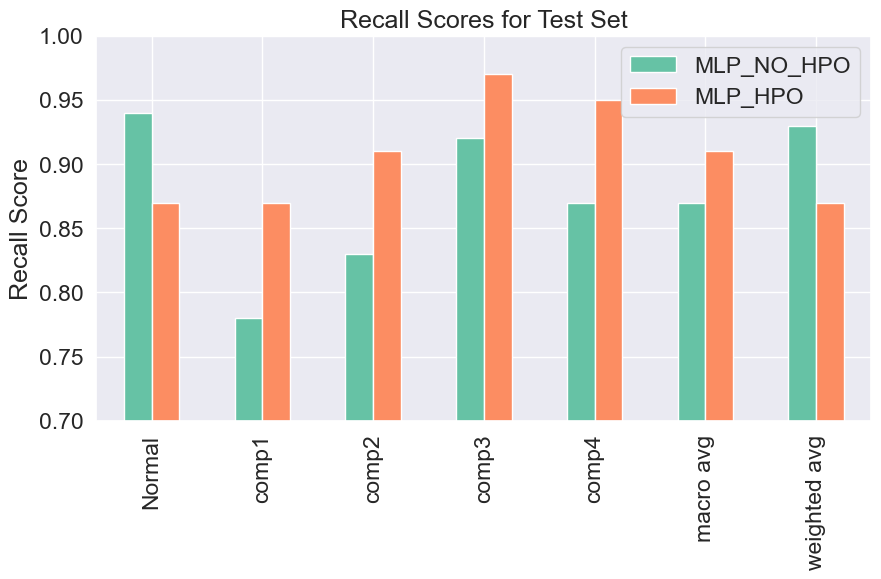

In [380]:
recall_test_comb.plot(kind="bar", figsize=(10, 5), rot=0)
plt.ylim(0.7, 1.0)
# xlabels vertical
plt.xticks(rotation=90)
plt.title("Recall Scores for Test Set")
plt.ylabel("Recall Score")
plt.show()

For now, we only run the experiment with 25 trials. Obviously, if we run it longer, we might improve it further. 

## LightGBM 

Lets see how LightGBM, a boosting algorithm performs. Typically, the boosting algorithms work really well on tabular data. 

In [361]:
# Reverse the one-hot encoding of the labels, lightgbm requires the labels to be integers
y_train_decoded = np.argmax(y_train, axis=1)

In [368]:
# create a lightgbm classifier
lgbm = LGBMClassifier(
    objective="multiclass", num_class=5, random_state=5, class_weight="balanced"
)

# fit the classifier to the training data
lgbm.fit(X_train, y_train_decoded)

# predict on the test data
y_pred = lgbm.predict(X_test)

In [409]:
# confusion matrix
y_test_decoded = np.argmax(y_test, axis=1)
cm_lgbm = confusion_matrix(y_test_decoded, y_pred)
df_cm_lgbm = pd.DataFrame(cm_lgbm, index=labels, columns=labels)
df_cm_lgbm

,Normal,comp1,comp2,comp3,comp4
Normal,115779,761,843,130,354
comp1,28,1021,39,1,14
comp2,68,2,1704,15,27
comp3,10,2,1,722,2
comp4,6,7,17,0,953


In [377]:
report_lgbm = classification_report(y_test_decoded, y_pred, output_dict=True)
# convert the report to a dataframe
report_lgbm = pd.DataFrame(report_lgbm).transpose()
print(report_lgbm)
recall_test_lgbm = get_recall_scores(report_lgbm)
recall_test_lgbm

              precision    recall  f1-score        support
0              0.999034  0.982285  0.990589  117867.000000
1              0.569437  0.925657  0.705110    1103.000000
2              0.654378  0.938326  0.771041    1816.000000
3              0.831797  0.979647  0.899688     737.000000
4              0.705926  0.969481  0.816974     983.000000
accuracy       0.981005  0.981005  0.981005       0.981005
macro avg      0.752114  0.959079  0.836680  122506.000000
weighted avg   0.986699  0.981005  0.982824  122506.000000


,recall
Normal,0.98
comp1,0.93
comp2,0.94
comp3,0.98
comp4,0.97
macro avg,0.96
weighted avg,0.98


This is quite remarkable. The defauly LightGBM model achived a macro average recall value of 0.96. All recall scores are above 0.93. 

Amazing! 

### Plot the evaluation results 

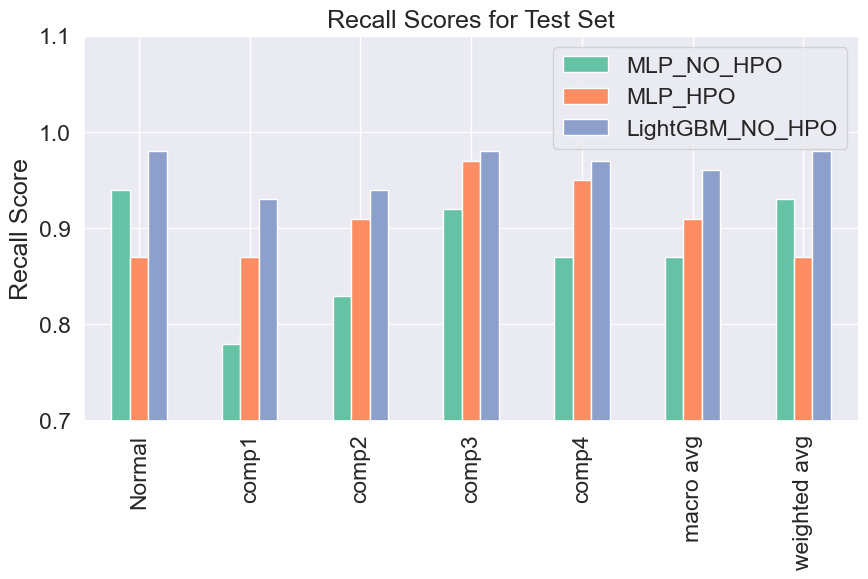

In [381]:
recall_test_lgbm = pd.DataFrame(recall_test_lgbm)
recall_test_lgbm.columns = ["LightGBM_NO_HPO"]
recall_test_comb = pd.concat([recall_test_comb, recall_test_lgbm], axis=1)
recall_test_comb.plot(kind="bar", figsize=(10, 5), rot=0)
plt.ylim(0.7, 1.1)
# xlabels vertical
plt.xticks(rotation=90)
plt.title("Recall Scores for Test Set")
plt.ylabel("Recall Score")
plt.show()

### Feature Importance

This is also the other added advantage of tree based models. They provide a feature importance 

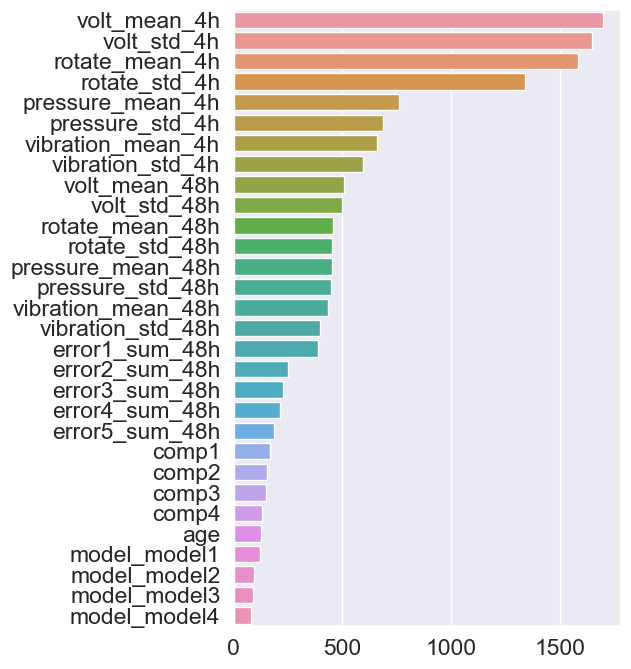

In [386]:
# Feature importance

# get the feature importance
feature_importance = lgbm.feature_importances_

# sort the feature importance in descending order
feature_importance = sorted(feature_importance, reverse=True)
# fig size
plt.figure(figsize=(5, 8))
# plot the feature importance using seaborn
sns.barplot(x=feature_importance, y=feature_list)
plt.show()

The short term lag features were the top ones. Among them, voltage is the most important one. 